## ON BALANCE VOLUME


### THEORY ABOUT OBV 

On-balance volume (OBV) is a technical trading momentum indicator that uses volume flow to predict changes in stock price. Joseph Granville first developed the OBV metric in the 1963 book Granville's New Key to Stock Market Profits.  He believed that when volume increases sharply without a significant change in the stock's price, the price will eventually jump upward or fall downward.

OBV shows crowd sentiment that can predict a bullish or bearish outcome. The Formula is the following: 

                   volume, if close>close prev
OBV=OBV prev   +   0, if close=close prev
                   −volume, if close<close prev

where:
OBV=Current on-balance volume level
OBV prev=Previous on-balance volume level
volume=Latest trading volume amount

Source: Investopedia 

In [75]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
import math
import pandas_datareader as web

### FUNCTIONS

In [125]:
def historical_graph(stock_code, start, end):
    df = web.DataReader(stock_code, data_source="yahoo", start=start, end=end)
    plt.figure(figsize=(16,8))
    plt.title(f"{stock_code} Closing Price")
    plt.plot(df["Close"])
    plt.xlabel("Date", fontsize = 18)
    plt.ylabel("Close Price USD ($)", fontsize = 18)

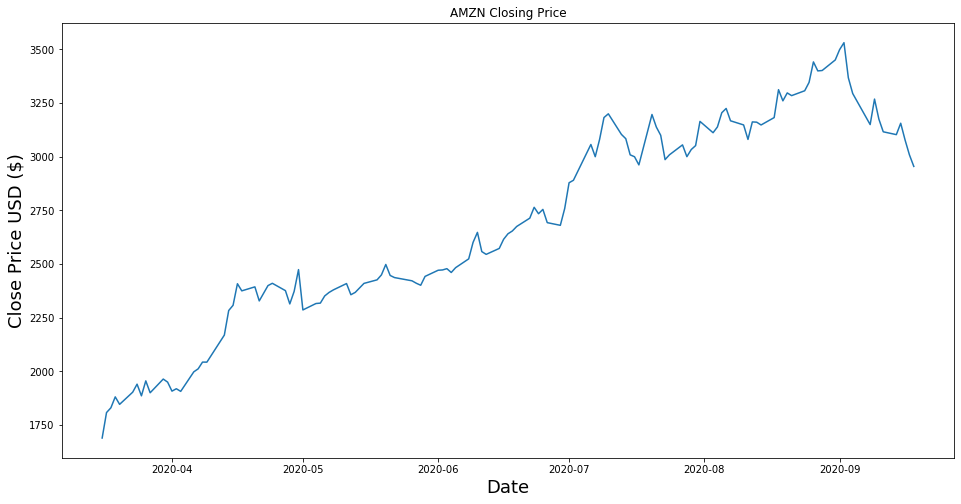

In [126]:
historical_graph("AMZN", "2020-03-16", "2020-09-18")

In [121]:
def OBV(stock, start, end):
    df = web.DataReader(stock, data_source="yahoo", start=start, end=end)
    #Calculate the On Balance Volume (OBV)
    OBV = []
    OBV.append(0)
    #Loop through the data set from the second row (index1) to the end of the data set
    for i in range(1, len(df.Close)):
        if df.Close[i] > df.Close[i-1]:
            OBV.append(OBV[-1] + df.Volume[i])
        elif df.Close[i] < df.Close[i-1]:
            OBV.append(OBV[-1] - df.Volume[i])
        else:
            OBV.append(OBV[-1])
    #Store the OBV and the Exponential Moving Average into new columns
    df["OBV"] = OBV
    df["OBV_EMA"] = df["OBV"].ewm(span=20).mean()
    #Plotting
    plt.figure(figsize=(12.2, 4.5))
    plt.plot(df["OBV"], label = "OBV", color = "orange")
    plt.plot(df["OBV_EMA"], label = "OBV_EMA", color = "purple")
    plt.title("OBV")
    plt.xlabel("Date", fontsize = 18)
    plt.ylabel(f"{stock}Price USD", fontsize = 18)
    plt.show()

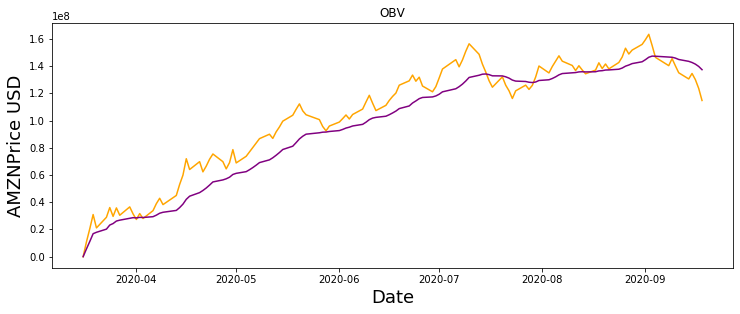

In [122]:
OBV("AMZN", "2020-03-16", "2020-09-18")

In [132]:
def buy_sell_timing(stock, start, end):
    df = web.DataReader(stock, data_source="yahoo", start=start, end=end)
    #Calculate the On Balance Volume (OBV)
    OBV = []
    OBV.append(0)
    #Loop through the data set from the second row (index1) to the end of the data set
    for i in range(1, len(df.Close)):
        if df.Close[i] > df.Close[i-1]:
            OBV.append(OBV[-1] + df.Volume[i])
        elif df.Close[i] < df.Close[i-1]:
            OBV.append(OBV[-1] - df.Volume[i])
        else:
            OBV.append(OBV[-1])
    #Store the OBV and the Exponential Moving Average into new columns
    df["OBV"] = OBV
    df["OBV_EMA"] = df["OBV"].ewm(span=20).mean()
    def buy_sell(signal, col1, col2):
        sigPriceBuy = []
        sigPriceSell = []
        flag = -1
        #Loop through the lenght of the data set
        for i in range(0, len(signal)):
            #IF OBV > OBV_EMA then Buy
            if signal[col1][i] > signal[col2][i] and flag != 1:
                sigPriceBuy.append(signal["Close"][i])
                sigPriceSell.append(np.nan)
                flag = 1
            #If OBV < OBV_EMA then sell
            elif signal[col1][i] < signal[col2][i] and flag != 0:
                sigPriceSell.append(signal["Close"][i])
                sigPriceBuy.append(np.nan)
                flag = 0
            else:
                sigPriceSell.append(np.nan)
                sigPriceBuy.append(np.nan)
        return (sigPriceBuy, sigPriceSell)
    x = buy_sell(df, "OBV", "OBV_EMA")
    df["Buy_Signal_Price"] = x[0]
    df["Sell_Signal_Price"] = x[1]
    #Plot the result
    plt.figure(figsize=(12.2, 4.5))
    plt.plot(df["Close"], label = "Close", alpha = 0.35)
    plt.scatter(df.index, df["Buy_Signal_Price"], label = "Buy Signal", marker =  "^", alpha = 1, color = "green")
    plt.scatter(df.index, df["Sell_Signal_Price"], label = "Sell Signal", marker = "v", alpha = 1, color = "red")
    plt.title(f"{stock} Buy and Sell Signals")
    plt.xlabel("Date", fontsize = 18)
    plt.ylabel("Price USD", fontsize = 18)
    plt.legend(loc = "upper left")
    plt.show()

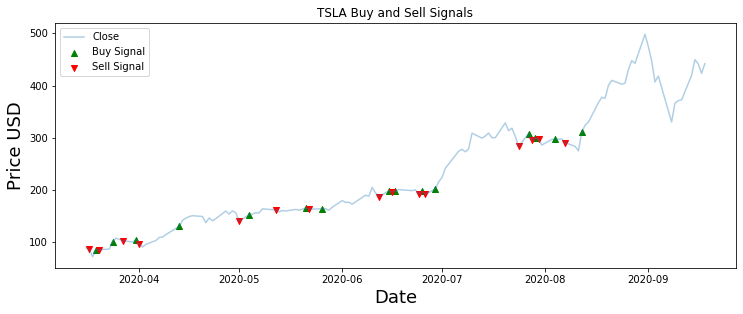

In [133]:
buy_sell_timing("TSLA", "2020-03-16", "2020-09-18")

OBJETIVO: Conseguir una función que nos diga si siguiendo este modelo habríamos ganado o no dinero. Para ello utilizaremos un valor ficticio de 10000 euros/dolares (dependiendo del stock) para calcular el beneficio en porcentaje. 

In [270]:
def profitability(stock, start, end):
    #We apply the previous function in order to get the sell and buy moments
    buy_sell_timing(stock, start, end)
    #Then we create a new dataframe to analyze this moments
    measure = df[["Buy_Signal_Price", "Sell_Signal_Price"]]
    #We substitute Nans with 0s
    measure["Buy_0"] = measure["Buy_Signal_Price"].fillna(0)
    measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)
    #We find the money someone would end up with using the strategy starting with 10000
    money = 10000
    for i in range(0, (len(measure["Buy_0"] + 1))):
    #for i in range(0, 17):
        if measure["Buy_0"][i] == 0 and measure["Sell_0"][i] == 0:
            pass
        elif measure["Buy_0"][i] != 0:
            shares = money/measure["Buy_0"][i]
        elif measure["Sell_0"][i] != 0:
            money = shares*measure["Sell_0"][i]
    #We find if the last movement is a sell or a purchase
    for i in range(0, (len(measure["Buy_0"] + 1))):
        if measure["Buy_0"][i] != 0:
            counter_buy = i
        if measure["Sell_0"][i] != 0:
            counter_sell = i
    #We calculate the money    
    if counter_sell > counter_buy:
        final_money = money
    else:
        final_money = shares*(df["Close"][-1])
    #We calculate the percentaje of profitability
    percentage = (final_money/10000) - 1
    return f"The percentage of profitability of this stock using OBV is {percentage}"

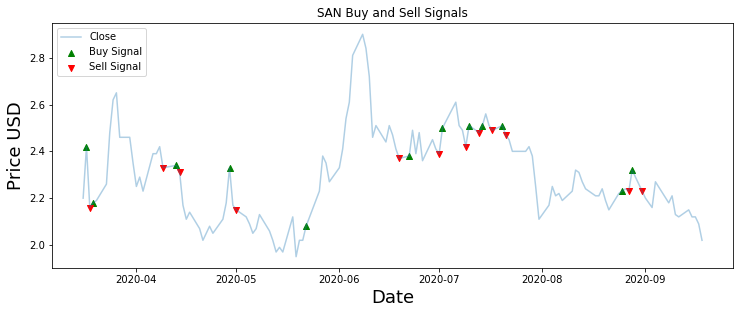

<ipython-input-270-d9502607b933>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Buy_0"] = measure["Buy_Signal_Price"].fillna(0)
<ipython-input-270-d9502607b933>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)


'The percentage of profitability of this stock using OBV is 0.6814756837068021'

In [271]:
profitability("SAN", "2020-03-16", "2020-09-18")

Y además, si habríamos ganado más dinero que comprando en el primer momento y dejarlo desarrollarse. 

### DRAFT TO FIND THE FUNCTIONS 

In [151]:
df = web.DataReader("AMZN", data_source="yahoo", start="2020-03-16", end="2020-09-18")

In [152]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-16,1759.449951,1626.030029,1641.510010,1689.150024,8917300,1689.150024
2020-03-17,1857.780029,1689.239990,1775.469971,1807.839966,10917100,1807.839966
2020-03-18,1841.660034,1745.000000,1750.000000,1830.000000,9645200,1830.000000
2020-03-19,1945.000000,1832.650024,1860.000000,1880.930054,10399900,1880.930054
2020-03-20,1957.000000,1820.729980,1926.310059,1846.089966,9817900,1846.089966
...,...,...,...,...,...,...
2020-09-14,3187.389893,3096.000000,3172.939941,3102.969971,4529600,3102.969971
2020-09-15,3175.020020,3108.919922,3136.159912,3156.129883,4021500,3156.129883
2020-09-16,3187.239990,3074.149902,3179.989990,3078.100098,4512200,3078.100098


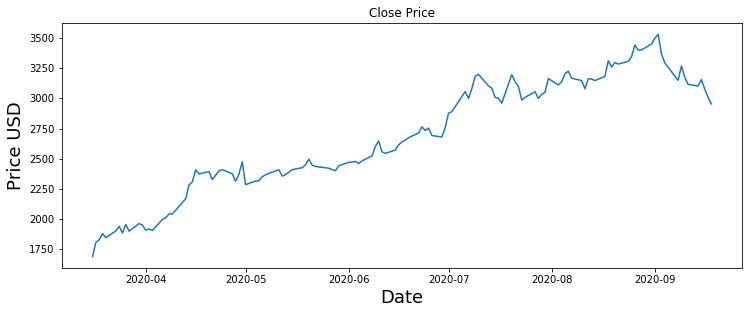

In [153]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df["Close"], label = "Close")
plt.title("Close Price")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price USD", fontsize = 18)
plt.show()

In [154]:
#Calculate the On Balance Volume (OBV)
OBV = []
OBV.append(0)

#Loop through the data set from the second row (index1) to the end of the data set
for i in range(1, len(df.Close)):
    if df.Close[i] > df.Close[i-1]:
        OBV.append(OBV[-1] + df.Volume[i])
    elif df.Close[i] < df.Close[i-1]:
        OBV.append(OBV[-1] - df.Volume[i])
    else:
        OBV.append(OBV[-1])

In [155]:
#Store the OBV and the Exponential Moving Average into new columns
df["OBV"] = OBV
df["OBV_EMA"] = df["OBV"].ewm(span=20).mean()

In [156]:
df

,High,Low,Open,Close,Volume,Adj Close,OBV,OBV_EMA
Date,,,,,,,,
2020-03-16,1759.449951,1626.030029,1641.510010,1689.150024,8917300,1689.150024,0,0.000000e+00
2020-03-17,1857.780029,1689.239990,1775.469971,1807.839966,10917100,1807.839966,10917100,5.731478e+06
2020-03-18,1841.660034,1745.000000,1750.000000,1830.000000,9645200,1830.000000,20562300,1.117727e+07
2020-03-19,1945.000000,1832.650024,1860.000000,1880.930054,10399900,1880.930054,30962200,1.688887e+07
2020-03-20,1957.000000,1820.729980,1926.310059,1846.089966,9817900,1846.089966,21144300,1.791822e+07
...,...,...,...,...,...,...,...,...
2020-09-14,3187.389893,3096.000000,3172.939941,3102.969971,4529600,3102.969971,130608000,1.435422e+08
2020-09-15,3175.020020,3108.919922,3136.159912,3156.129883,4021500,3156.129883,134629500,1.426934e+08
2020-09-16,3187.239990,3074.149902,3179.989990,3078.100098,4512200,3078.100098,130117300,1.414957e+08


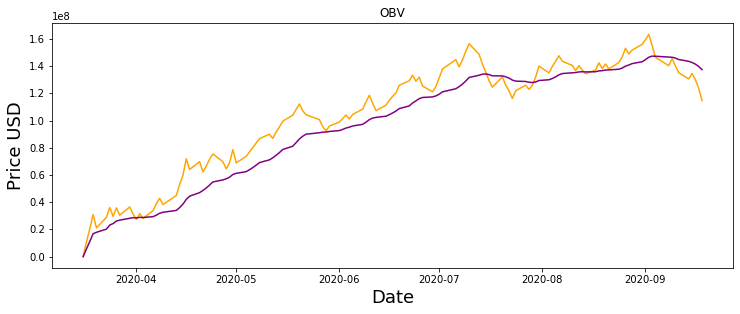

In [157]:
#Create and plot the graph
plt.figure(figsize=(12.2, 4.5))
plt.plot(df["OBV"], label = "OBV", color = "orange")
plt.plot(df["OBV_EMA"], label = "OBV_EMA", color = "purple")
plt.title("OBV")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price USD", fontsize = 18)
plt.show()


La idea de este método es comprar cuando la línea de OBV está por encima de la línea de OBV_EMA.

In [158]:
#Create a function to signal when to buy and when to sell the stock
#IF OBV > OBV_EMA then Buy
#If OBV < OBV_EMA then sell
#else do nothing

In [203]:
def buy_sell(signal, col1, col2):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1
    #Loop through the lenght of the data set
    for i in range(0, len(signal)):
        #IF OBV > OBV_EMA then Buy
        if signal[col1][i] > signal[col2][i] and flag != 1:
            sigPriceBuy.append(signal["Close"][i])
            sigPriceSell.append(np.nan)
            flag = 1
        #If OBV < OBV_EMA then sell
        elif signal[col1][i] < signal[col2][i] and flag != 0:
            sigPriceSell.append(signal["Close"][i])
            sigPriceBuy.append(np.nan)
            flag = 0
        else:
            sigPriceSell.append(np.nan)
            sigPriceBuy.append(np.nan)
    return (sigPriceBuy, sigPriceSell)

In [204]:
#Create buy and sell columns 
x = buy_sell(df, "OBV", "OBV_EMA")
df["Buy_Signal_Price"] = x[0]
df["Sell_Signal_Price"] = x[1]
df

,High,Low,Open,Close,Volume,Adj Close,OBV,OBV_EMA,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,
2020-03-16,1759.449951,1626.030029,1641.510010,1689.150024,8917300,1689.150024,0,0.000000e+00,NaN,NaN
2020-03-17,1857.780029,1689.239990,1775.469971,1807.839966,10917100,1807.839966,10917100,5.731478e+06,1807.839966,NaN
2020-03-18,1841.660034,1745.000000,1750.000000,1830.000000,9645200,1830.000000,20562300,1.117727e+07,NaN,NaN
2020-03-19,1945.000000,1832.650024,1860.000000,1880.930054,10399900,1880.930054,30962200,1.688887e+07,NaN,NaN
2020-03-20,1957.000000,1820.729980,1926.310059,1846.089966,9817900,1846.089966,21144300,1.791822e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-09-14,3187.389893,3096.000000,3172.939941,3102.969971,4529600,3102.969971,130608000,1.435422e+08,NaN,NaN
2020-09-15,3175.020020,3108.919922,3136.159912,3156.129883,4021500,3156.129883,134629500,1.426934e+08,NaN,NaN
2020-09-16,3187.239990,3074.149902,3179.989990,3078.100098,4512200,3078.100098,130117300,1.414957e+08,NaN,NaN


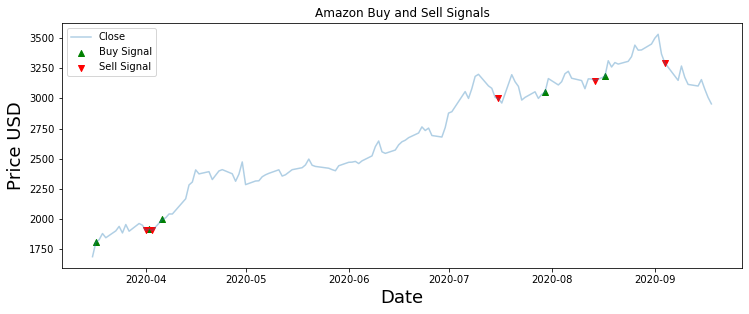

In [205]:
#Plot the result
plt.figure(figsize=(12.2, 4.5))
plt.plot(df["Close"], label = "Close", alpha = 0.35)
plt.scatter(df.index, df["Buy_Signal_Price"], label = "Buy Signal", marker =  "^", alpha = 1, color = "green")
plt.scatter(df.index, df["Sell_Signal_Price"], label = "Sell Signal", marker = "v", alpha = 1, color = "red")
plt.title("Amazon Buy and Sell Signals")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price USD", fontsize = 18)
plt.legend(loc = "upper left")
plt.show()

Now I´m going to estimate the amount of money made with this stock following this type of strategy. 

In [162]:
measure = df[["Buy_Signal_Price", "Sell_Signal_Price"]]

In [212]:
measure["Buy_0"] = measure["Buy_Signal_Price"].fillna(0)
measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)

<ipython-input-212-611e5bee9884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)


In [215]:
measure.drop("Buy_Signal_Price", axis = 1, inplace=True)
measure.drop("Sell_Signal_Price", axis = 1, inplace=True)

/Users/Jaime/opt/anaconda3/envs/ironhack/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [224]:
money = 10000
for i in range(0, (len(measure["Buy_0"] + 1))):
#for i in range(0, 17):
    if measure["Buy_0"][i] == 0 and measure["Sell_0"][i] == 0:
        pass
    elif measure["Buy_0"][i] != 0:
        shares = money/measure["Buy_0"][i]
    elif measure["Sell_0"][i] != 0:
        money = shares*measure["Sell_0"][i]
print(f"Final {money} $ if a sell was the last movement")
print(f"Final {shares} shares if a buy was the last movement")

Final 16814.75683706802 $ if a sell was the last movement
Final 5.1037012581050405 shares if a buy was the last movement


¿What was the last movement a sell or a buy?

In [237]:
measure["Buy_0"][1] != 0

True

In [255]:
for i in range(0, (len(measure["Buy_0"] + 1))):
    if measure["Buy_0"][i] != 0:
        counter_buy = i
    if measure["Sell_0"][i] != 0:
        counter_sell = i
        

In [254]:
print(counter_buy)
print(counter_sell)

107
121


In [258]:
if counter_sell > counter_buy:
    final_money = money
else:
    final_money = shares*(df["Close"][-1])
print(final_money)

16814.75683706802


OBV it´s not a perfect indicator, there is none that is, we need to use other indicators for more information in where to buy and sell the stock

### Let´s try it with another stock

In [114]:
df = web.DataReader("SAN", data_source="yahoo", start="2020-03-16", end="2020-09-18")

In [115]:
#Calculate the On Balance Volume (OBV)
OBV = []
OBV.append(0)

#Loop through the data set from the second row (index1) to the end of the data set
for i in range(1, len(df.Close)):
    if df.Close[i] > df.Close[i-1]:
        OBV.append(OBV[-1] + df.Volume[i])
    elif df.Close[i] < df.Close[i-1]:
        OBV.append(OBV[-1] - df.Volume[i])
    else:
        OBV.append(OBV[-1])

In [116]:
#Store the OBV and the Exponential Moving Average into new columns
df["OBV"] = OBV
df["OBV_EMA"] = df["OBV"].ewm(span=20).mean()

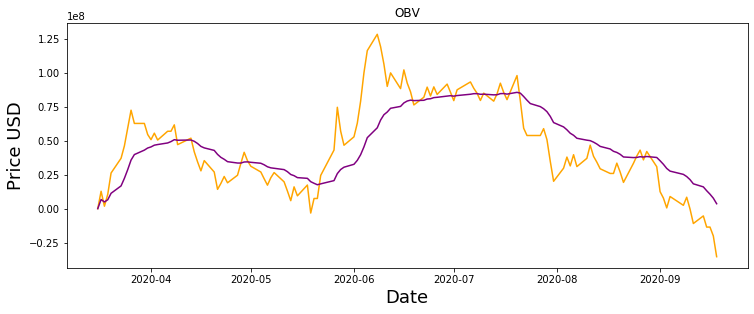

In [117]:
#Create and plot the graph
plt.figure(figsize=(12.2, 4.5))
plt.plot(df["OBV"], label = "OBV", color = "orange")
plt.plot(df["OBV_EMA"], label = "OBV_EMA", color = "purple")
plt.title("OBV")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price USD", fontsize = 18)
plt.show()


In [118]:
x = buy_sell(df, "OBV", "OBV_EMA")
df["Buy_Signal_Price"] = x[0]
df["Sell_Signal_Price"] = x[1]

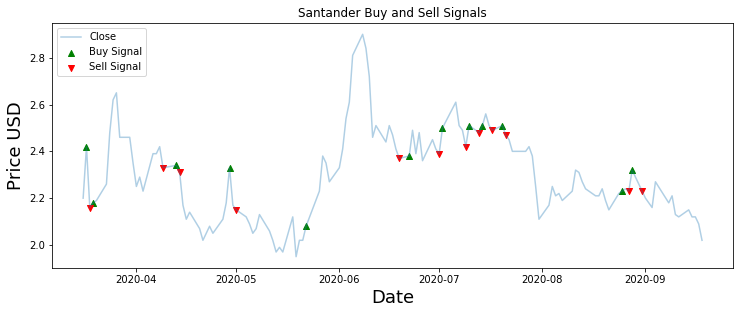

In [120]:
#Plot the result
plt.figure(figsize=(12.2, 4.5))
plt.plot(df["Close"], label = "Close", alpha = 0.35)
plt.scatter(df.index, df["Buy_Signal_Price"], label = "Buy Signal", marker =  "^", alpha = 1, color = "green")
plt.scatter(df.index, df["Sell_Signal_Price"], label = "Sell Signal", marker = "v", alpha = 1, color = "red")
plt.title("Santander Buy and Sell Signals")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price USD", fontsize = 18)
plt.legend(loc = "upper left")
plt.show()